In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as Func

In [2]:
spark = SparkSession.builder.appName("ModularCSVLoader").getOrCreate()

# Base URL for all the CSV files
base_url = "datasets/"

# List of file names to process
file_names = [
"allergies.csv",
"encounters.csv",
"medications.csv",
"patients.csv",
"procedures.csv"
]

# Dictionaries to store the resulting DataFrames for further processing/joining.
# pandas_dfs = {}
spark_dfs = {}

# Process each file and store the DataFrames into the dictionaries
for file_name in file_names:
    name_key = file_name.replace('.csv', '')
    file_url = f"{base_url}{file_name}"
    print(f"\nProcessing file: {file_name}")
    spark_df = spark.read.csv(file_url, header=True, inferSchema=True)
    # pandas_dfs[name_key] = pd_df
    spark_dfs[name_key] = spark_df

25/04/11 09:19:36 WARN Utils: Your hostname, debian-shed resolves to a loopback address: 127.0.1.1; using 192.168.1.11 instead (on interface enp3s0)
25/04/11 09:19:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/11 09:19:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Processing file: allergies.csv

Processing file: encounters.csv



Processing file: medications.csv



Processing file: patients.csv

Processing file: procedures.csv


Make Encounter DF

In [3]:
# filter encounters for Drug Overdose and STOPDATE > 1999-07-15
# date formate 2018-12-20 22:57:39
enc_df = spark_dfs['encounters'].filter(
    (spark_dfs['encounters'].REASONCODE == '55680006') &
    (
        Func.to_timestamp(spark_dfs['encounters'].STOP, "yyyy-MM-dd HH:mm:ss") >
        Func.lit("1999-07-15 00:00:00")
    )
)

enc_df.show(5)

+--------------------+-------------------+-------------------+--------------------+--------------------+--------------+--------+--------------------+------+----------+-----------------+
|                  Id|              START|               STOP|             PATIENT|            PROVIDER|ENCOUNTERCLASS|    CODE|         DESCRIPTION|  COST|REASONCODE|REASONDESCRIPTION|
+--------------------+-------------------+-------------------+--------------------+--------------------+--------------+--------+--------------------+------+----------+-----------------+
|2a917920-2701-49f...|2003-03-31 21:50:51|2003-04-08 13:20:43|708b81c9-21a9-411...|fb37c581-84a6-351...|     emergency|50849002|Emergency Room Ad...|105.37|  55680006|    Drug overdose|
|22874b3d-0873-40e...|2012-02-18 21:50:51|2012-02-28 21:12:17|708b81c9-21a9-411...|fb37c581-84a6-351...|     emergency|50849002|Emergency Room Ad...|105.37|  55680006|    Drug overdose|
|134c5ee3-1b72-4e3...|2013-08-03 21:50:51|2013-08-13 07:44:52|708b81c9

In [4]:
patient_df = spark_dfs['patients'].filter((spark_dfs['patients'].BIRTHDATE.isNotNull()) 
    # &
    # (
    #     Func.to_timestamp(spark_dfs['patients'].DEATHDATE, "yyyy-MM-dd HH:mm:ss") < Func.current_timestamp()
    # )      
    # &
    # (
    #     Func.floor(
    #         Func.datediff(
    #             Func.current_date(),
    #             Func.to_date(spark_dfs['patients'].BIRTHDATE, "yyyy-MM-dd HH:mm:ss")) / 365
    #     ).between(18, 35)
    # )
).show(5)

+--------------------+----------+---------+-----------+---------+----------+------+-----------+----------+------+------------+-------+-----+------------+------+--------------------+--------------------+-------------+------------+-----+
|                  Id| BIRTHDATE|DEATHDATE|        SSN|  DRIVERS|  PASSPORT|PREFIX|      FIRST|      LAST|SUFFIX|      MAIDEN|MARITAL| RACE|   ETHNICITY|GENDER|          BIRTHPLACE|             ADDRESS|         CITY|       STATE|  ZIP|
+--------------------+----------+---------+-----------+---------+----------+------+-----------+----------+------+------------+-------+-----+------------+------+--------------------+--------------------+-------------+------------+-----+
|3d8e57b2-3de5-4fb...|1943-03-11|       NA|999-86-7250|S99939389| X3970685X|  Mrs.|   Allyn942|Kreiger457|    NA|Bartoletti50|      M|asian|asian_indian|     F|Muhlenberg  Penns...|372 Marks Heights...|Middle Paxton|Pennsylvania|   NA|
|7f4ea9fb-f436-411...|1980-09-28|       NA|999-90-4314|S

In [5]:
# Assign the 'patients' DataFrame from spark_dfs to patient_df
patient_df = spark_dfs['patients']

# Filter the DataFrame where DEATHDATE is 'NA'
patient_df.filter(
    Func.lit('NA') != patient_df.DEATHDATE
).show(5)

+--------------------+----------+----------+-----------+---------+----------+------+---------+--------------+------+---------+-------+-----+-----------+------+--------------------+--------------------+---------------+------------+-----+
|                  Id| BIRTHDATE| DEATHDATE|        SSN|  DRIVERS|  PASSPORT|PREFIX|    FIRST|          LAST|SUFFIX|   MAIDEN|MARITAL| RACE|  ETHNICITY|GENDER|          BIRTHPLACE|             ADDRESS|           CITY|       STATE|  ZIP|
+--------------------+----------+----------+-----------+---------+----------+------+---------+--------------+------+---------+-------+-----+-----------+------+--------------------+--------------------+---------------+------------+-----+
|65d1a989-1aa6-4a1...|1943-12-05|2006-12-08|999-28-7609|S99918683| X5025977X|  Mrs.|Nelida367|  Considine820|    NA|Hammes673|      M|white|    italian|     F|Bethel  Pennsylva...|328 Collier Cross...|North Middleton|Pennsylvania|   NA|
|502d81dc-3946-48f...|1955-04-05|1996-07-02|999-77-5

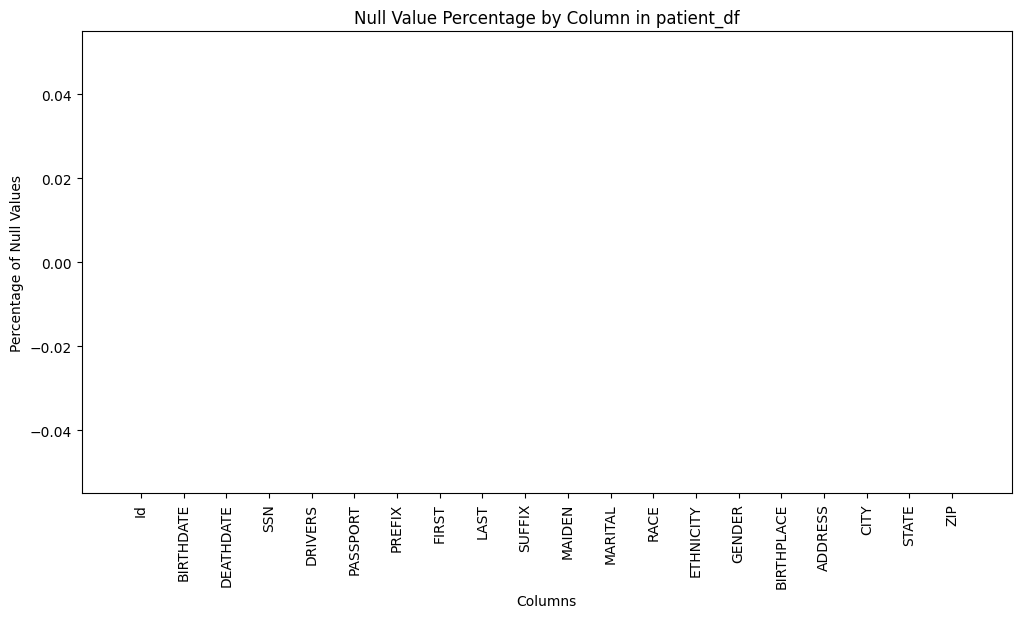

In [6]:
# %pip install matplotlib
import matplotlib.pyplot as plt  # type: ignore

# Count the total number of rows
total_rows = patient_df.count()

# Calculate the number of nulls for each column
null_counts = patient_df.select(
    [(Func.count(Func.when(Func.col(c).isNull(), c)) / total_rows).alias(c) for c in patient_df.columns]
).collect()[0]

# Convert the null counts to a dictionary
null_counts_dict = {col: null_counts[i] for i, col in enumerate(patient_df.columns)}

# Plot the null percentages
plt.figure(figsize=(12, 6))
plt.bar(null_counts_dict.keys(), null_counts_dict.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.title('Null Value Percentage by Column in patient_df')
plt.show()